# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [2]:
from models import matlabmodel as KOHmodel
from data.dataloadermatlab import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import ell2rho, beta2ell
from jax import jit

import numpy as np
import matplotlib.pyplot as plt

import arviz
import mici

from truefuncs import zeta, eta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

# The Data

In [3]:
dataloader = DataLoader('data/matlab/simple_field_medium.csv', 'data/matlab/simple_comp.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = KOHmodel.MatlabModel(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

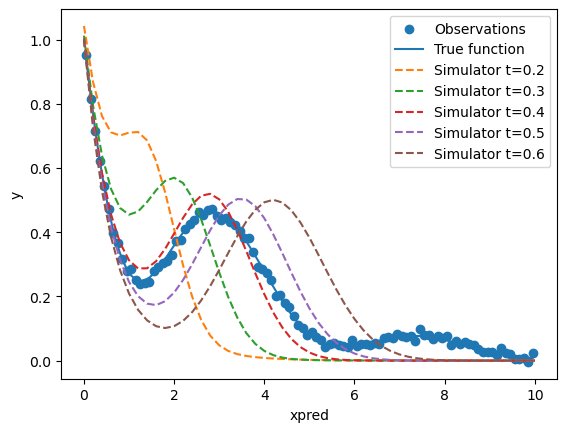

In [4]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4), label='True function')
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    rows = dataloader.tc==t
    ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t}')
ax.set_xlabel('xpred')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [5]:
init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    # map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [6]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0])
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[3]), 
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6])
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [7]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=lambda q: q * 0,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [8]:
seed = 1234
n_chain = 1 # only 1 works on MacOS
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.234),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'theta': state.pos[0], 
        'ell_eta_1': state.pos[1], 
        'ell_eta_2': state.pos[2],
        'lambda_eta': state.pos[3],
        'lambda_delta': state.pos[4],
        'lambda_epsilon': state.pos[5],
        'lambda_epsilon_eta': state.pos[6],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:00] > Slow adaptive (4/7) [00:00] > Slow adaptive (5/7) [00:02] > Slow adaptive (6/7) [00:04] > Slow adaptive (7/7) [00:11] > Final fast adaptive [00:00] > Main non-adaptive [00:49]

Chain 1/1: 100%|██████████|10000/10000 [00:49<00:00, 200.54it/s, accept_stat=0.257]

# Analyse MCMC output

In [9]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.352,0.077,-0.499,-0.220,0.004,0.003,392.0,714.0,NaN
ell_eta_1,-2.226,0.024,-2.271,-2.179,0.001,0.001,397.0,586.0,NaN
ell_eta_2,-1.278,0.050,-1.368,-1.178,0.002,0.002,426.0,664.0,NaN
lambda_eta,-1.716,0.195,-2.102,-1.374,0.010,0.007,410.0,683.0,NaN
lambda_delta,4.889,0.144,4.637,5.177,0.007,0.005,386.0,671.0,NaN
lambda_epsilon,9.105,0.313,8.531,9.699,0.014,0.010,511.0,620.0,NaN
lambda_epsilon_eta,11.253,0.111,11.045,11.458,0.005,0.004,478.0,947.0,NaN
hamiltonian,-867.591,2.605,-872.190,-862.893,0.094,0.067,787.0,1515.0,NaN


In [10]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

theta :  -0.3520327835300299 ± 0.07661659883370311
ell_eta_1 :  -2.2263307847055867 ± 0.023780168952452517
ell_eta_2 :  -1.277633172270067 ± 0.05019590308910859
lambda_eta :  -1.7160452547736837 ± 0.194934965611192
lambda_delta :  4.88907213095465 ± 0.14378614321631408
lambda_epsilon :  9.105307161813885 ± 0.31285806819469103
lambda_epsilon_eta :  11.25261166558748 ± 0.11139137147113179
hamiltonian :  -867.5909914536134 ± 2.6047887580174445


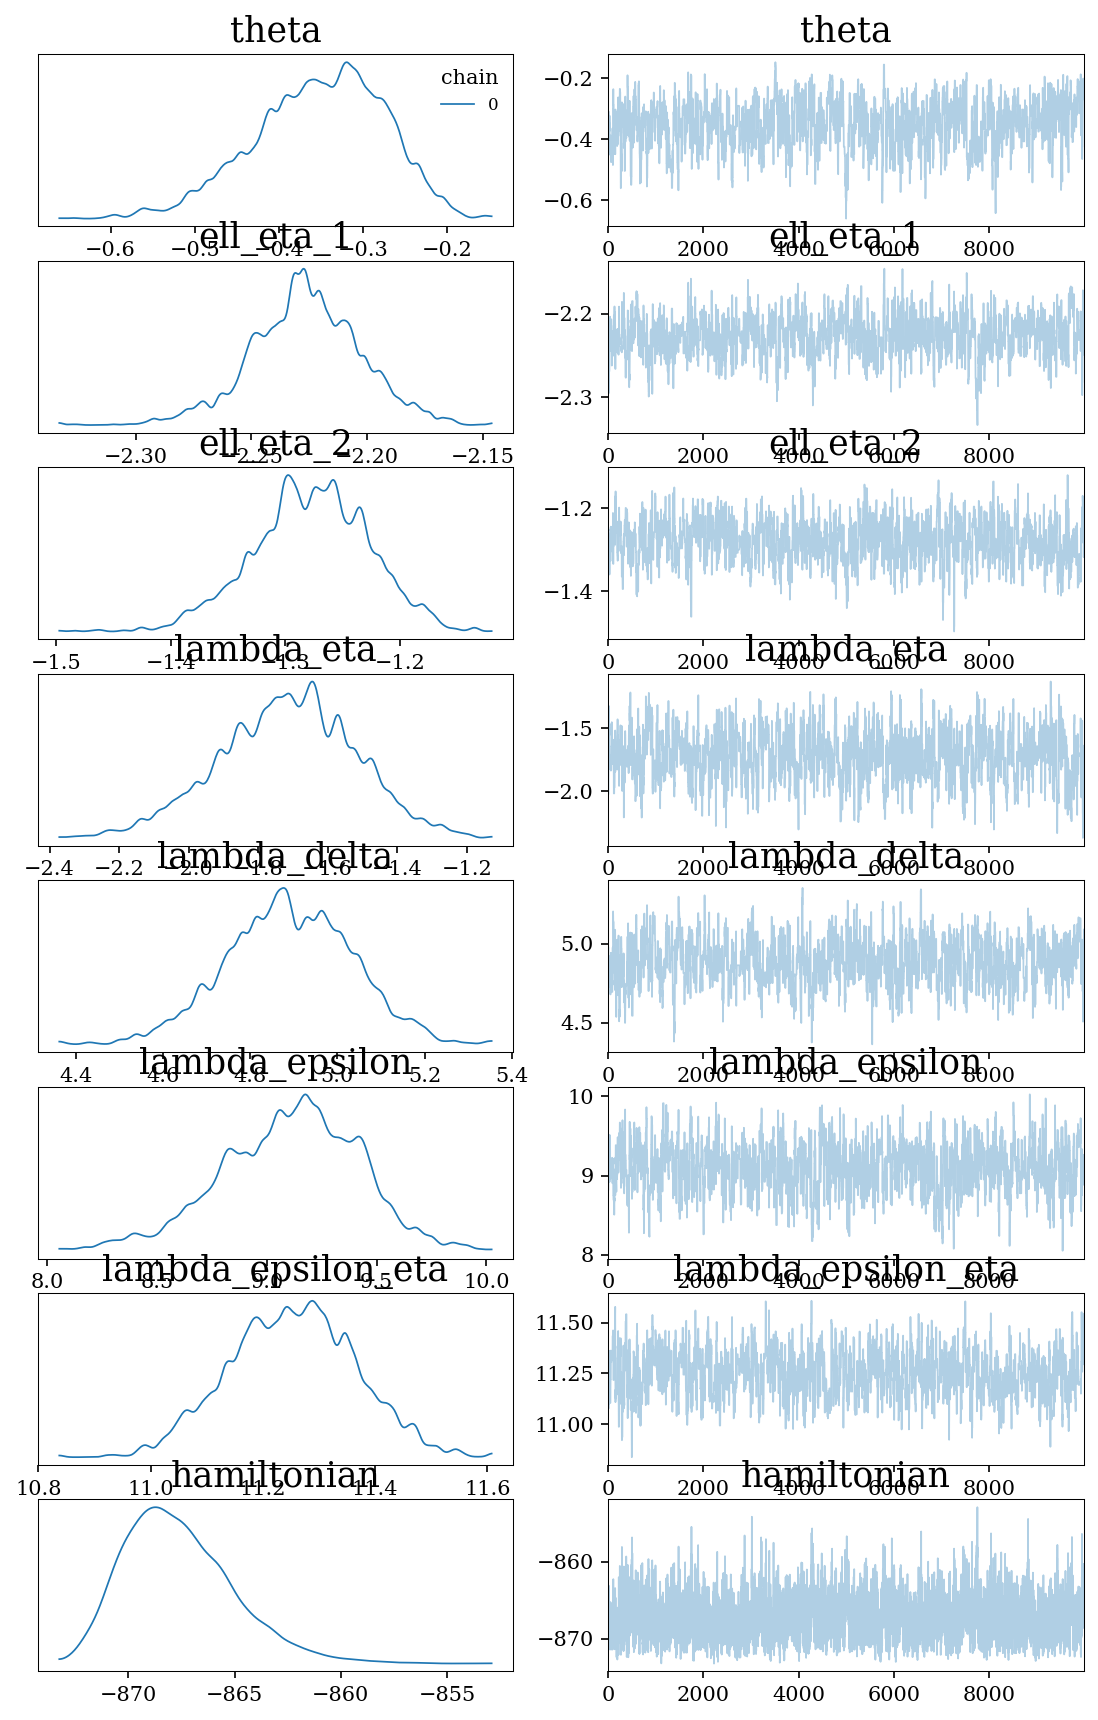

In [11]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()

# Transform the Chains

In [12]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'theta':
        traces_transformed[var] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var.startswith('ell'):
        traces_transformed[var] = mapRto0inf(trace[0])
    elif var.startswith('lambda'):
        traces_transformed[var] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.43479347957615627 ± 0.007400803554193666
ell_eta_1 :  0.10795418147367492 ± 0.0025628635463878844
ell_eta_2 :  0.2790462448223463 ± 0.013942827389940819
lambda_eta :  0.1831911348948941 ± 0.03550686838239897
lambda_delta :  134.20545734094551 ± 19.288407561173315
lambda_epsilon :  9441.353533483332 ± 2895.370831409444
lambda_epsilon_eta :  77560.47324885716 ± 8657.957808755697


In [13]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.435,0.007,0.422,0.449,0.000,0.000,392.0,713.0,NaN
ell_eta_1,0.108,0.003,0.103,0.113,0.000,0.000,397.0,586.0,NaN
ell_eta_2,0.279,0.014,0.250,0.303,0.001,0.000,426.0,664.0,NaN
lambda_eta,0.183,0.036,0.117,0.247,0.002,0.001,410.0,683.0,NaN
lambda_delta,134.205,19.289,99.472,171.025,0.979,0.693,386.0,671.0,NaN
lambda_epsilon,9441.354,2895.516,4115.548,14448.296,124.707,88.229,511.0,620.0,NaN
lambda_epsilon_eta,77560.473,8658.391,61100.098,92749.043,395.046,279.510,478.0,947.0,NaN


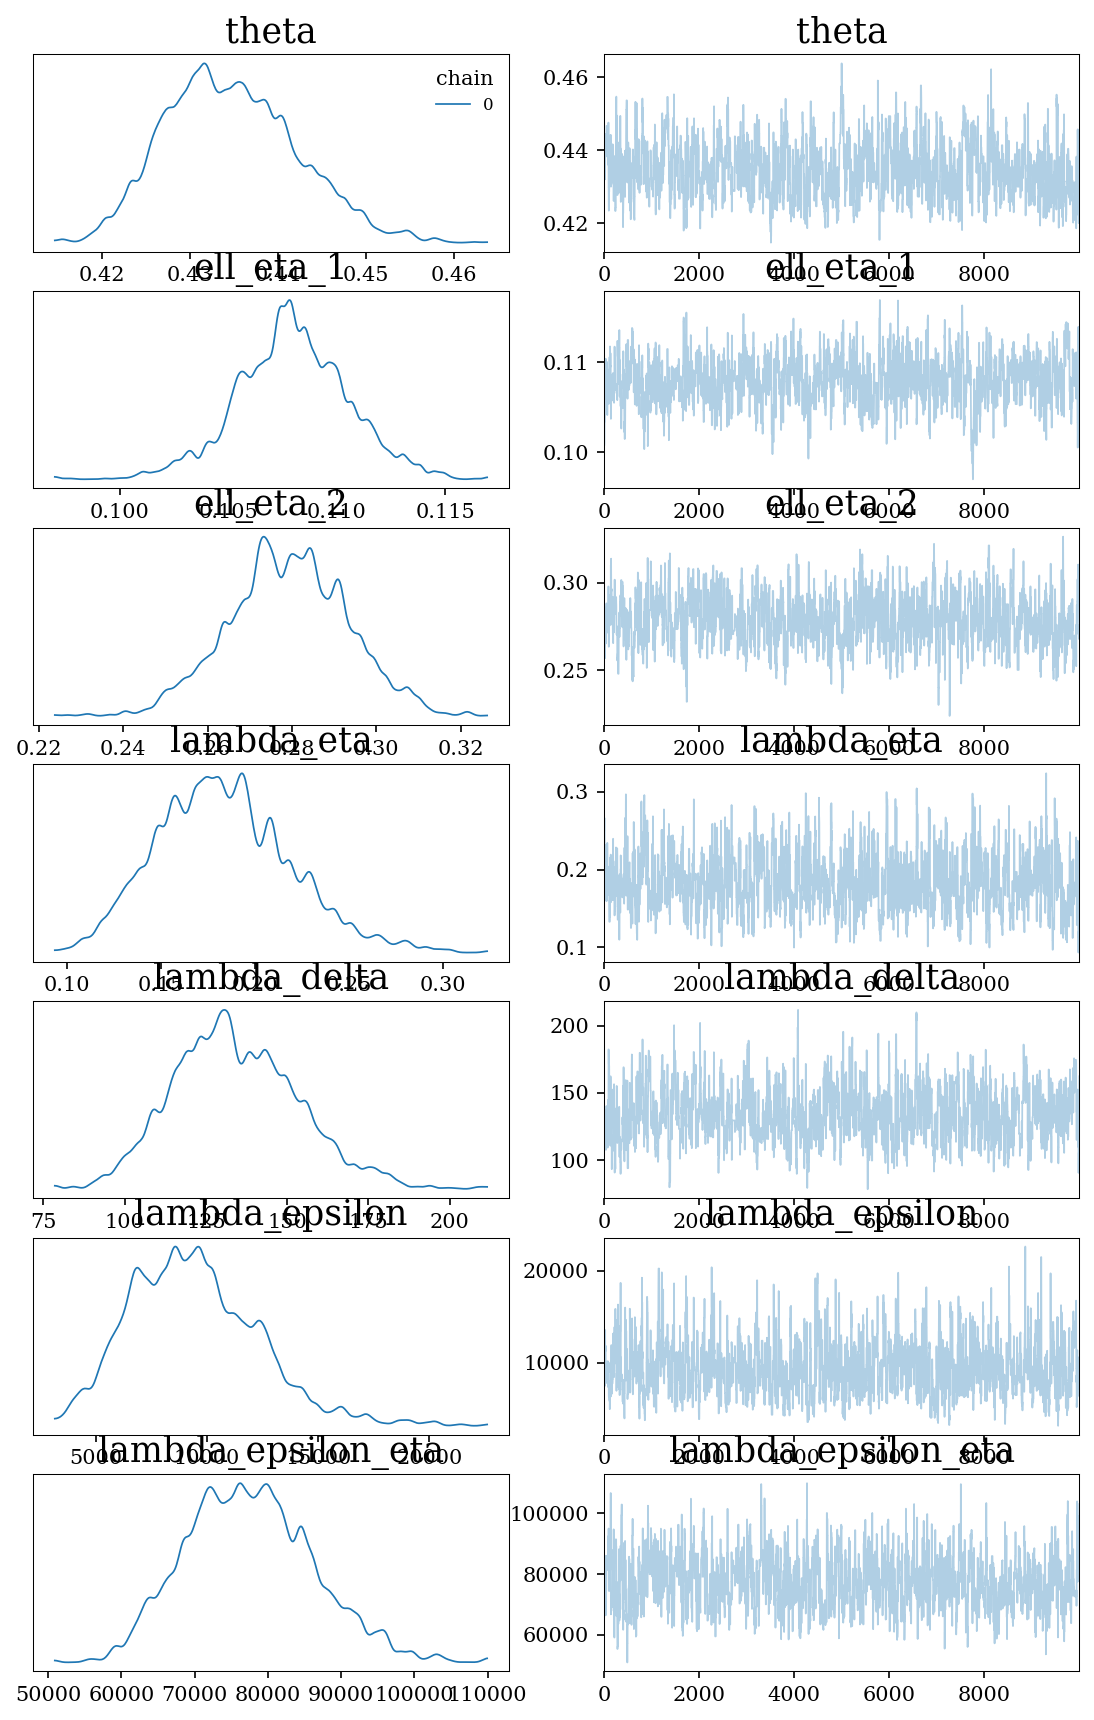

In [14]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()

# Analyse posterior fit

## Prediction data

In [15]:
xpred = np.linspace(0, 10, 1000) # for predictions

xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(np.mean(traces['theta'])) # transform theta back to [0, 1]

x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
dataset = model.dataset(theta_transformed)

## Posterior GPs

In [16]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
eta_pred_sd = np.sqrt(eta_pred_v)


zeta_pred_m = dataloader.inverse_transform_y(zeta_pred.mean()) # transform back to original scale
zeta_pred_v = dataloader.inverse_transform_y_cov(zeta_pred.variance()) # transform back to original scale
zeta_pred_sd = np.sqrt(zeta_pred_v)

obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
obs_pred_sd = np.sqrt(obs_pred_v)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Plot GP modelling simulator

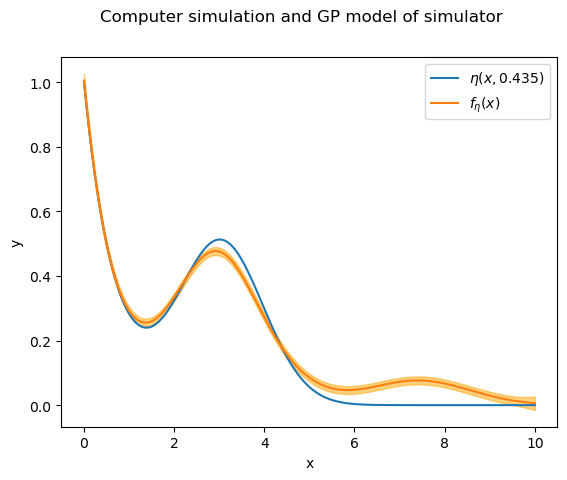

In [17]:
theta = params_transformed['theta']

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(xpred, eta(xpred, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

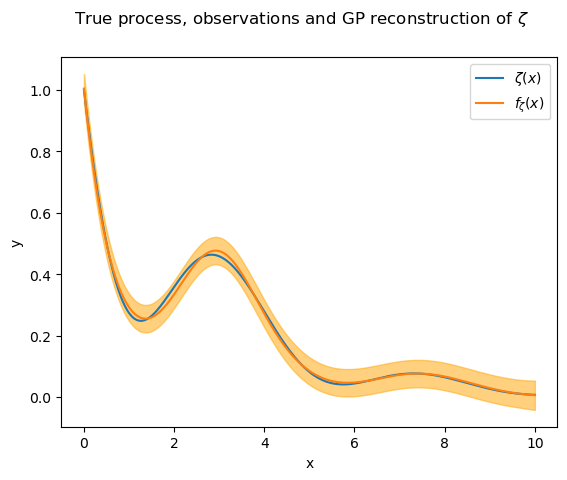

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(xpred, zeta(xpred), label=r'$\zeta(x)$')
ax.plot(xpred, zeta_pred_m, label=r'$f_\zeta(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

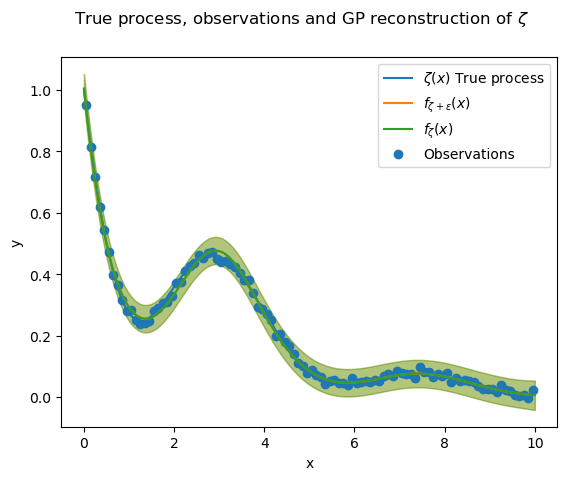

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(xpred, zeta(xpred), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(dataloader.xf, dataloader.yf, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Dicrepancy Testing

In [20]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

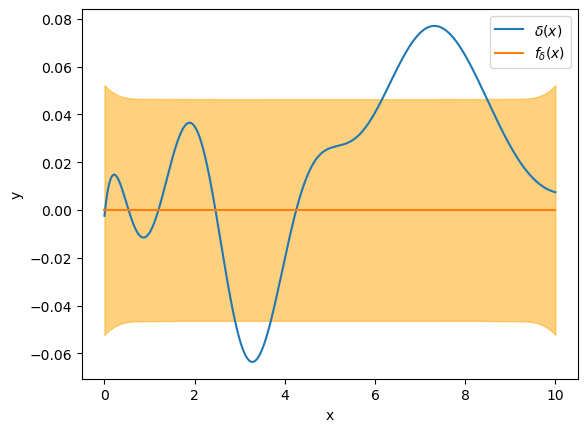

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(xpred, zeta(xpred) - eta(xpred, theta), label=r'$\delta(x)$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
# fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()